# Ames Housing Data model

Note- using the standard workflow from DSI lecture 3.06 and Basic Model code along with GA:DSI Echelon team and local team lead C. Schmitt.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df = pd.read_csv('datasets/train.csv', index_col = 'PID')
kaggle_test = pd.read_csv('datasets/test.csv', index_col = 'PID')

In [3]:
df.shape, kaggle_test.shape

((2051, 80), (878, 79))

# Purpose:

The primary purpose of this exercise is to develop a regression model that accurately predicts home values for homes at sale in the Ames Iowa Housing dataset consistent with the Kaggle Rules- https://www.kaggle.com/c/dsi-us-12-project-2-regression-challenge.

The primary question this 

By definition this will be looking at linear regression, lasso and ridge models with the goal of getting the Root Mean Squared Error (RMSE) as close to 0 as possible for the test data provided on Kaggle.

In [4]:
df.drop(df[df['Gr Liv Area'] > 4000].index, inplace = True)  
# jse.amstat.org recommends dropping any homes with greater 'GR Liv Area' greater than 4k sqft
# as they are outliers.

In [5]:
df = pd.get_dummies(df, columns = ["Neighborhood",
                                   "Roof Style",
                                   "Mas Vnr Type"
                                  ],
                    drop_first= True)

In [6]:
explanatory_vars = df.drop(columns = ['BsmtFin SF 1', 'Screen Porch',
                                      'Enclosed Porch', 'Kitchen AbvGr', 'Lot Frontage',
                                      'Id', 'Overall Cond', 'Mas Vnr Area',
                                      'Paved Drive', 'Sale Type', 'MS Zoning', 
                                      'Functional', 'Heating QC', 'House Style', 
                                      'Lot Frontage', 'MS SubClass', 'Bsmt Half Bath',
                                      'Low Qual Fin SF', 'Yr Sold', 'Misc Val', 
                                      'BsmtFin SF 2', 'Pool Area', 'Mo Sold', '3Ssn Porch', 
                                      'Bedroom AbvGr', 'Bsmt Unf SF', '2nd Flr SF',
                                      'Half Bath', 'Bsmt Full Bath', "Lot Area",
                                      'Wood Deck SF', 'Open Porch SF', 'Street',
                                      'Alley', 'Lot Shape', 'Land Contour',
                                      'Utilities', 'Lot Config', 'Land Slope',
                                      'Condition 1', 'Condition 2', 'Garage Cars',
                                      'Bldg Type', 'House Style', 
                                      'Roof Matl', 'Exterior 1st', 'Exterior 2nd',
                                      'Exter Qual', 'Exter Cond',
                                      'Foundation', 'Bsmt Qual', 'Bsmt Cond',
                                      'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2',
                                      'Heating', 'Electrical', 'Kitchen Qual', 
                                      "Fireplace Qu", 'Garage Type', 'Garage Finish',
                                      'Garage Qual', 'Garage Cond', 'Paved Drive',
                                      'Pool QC', 'Fence', 'Misc Feature', 
                                      'Central Air', 'Garage Yr Blt',
                                     ]).columns
# I'm going to start with the first 3 most strongly positively correlated values and 
# the single most strongly negatively correllated
# let's see what I've got.
# adding in two vars to 2nd iteration- 'Lot Area', 'Full Bath'

# third iteration flipping the script, looking at all numerical columns 
# where the correlation value is  > abs(0.4)

In [7]:
model = df[explanatory_vars].copy()
# in this case I am assuming the value of Garage area and Garage Cars being unknown to mean no garage and therefore 0.

In [8]:
model.dropna(inplace = True)

## Train-Test-Split

In [9]:
X = model.drop(columns = 'SalePrice')
y = np.log(model['SalePrice'])

In [10]:
ss = StandardScaler()
ss.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [12]:
Z_train = ss.transform(X_train)

In [13]:
Z_test = ss.transform(X_test)

## Model

##### Linear Regression

In [14]:
ols = LinearRegression()
ols.fit(Z_train, y_train);

#### LASSO CV

In [15]:
l_alphas = np.logspace(-3, 10, 100)
lasso_cv = LassoCV(alphas = l_alphas, cv = 5)
lasso_cv.fit(Z_train, y_train);

#### Ridge CV

In [16]:
r_alphas = np.logspace(0, 1, 100)
ridge_cv = RidgeCV(
    alphas = r_alphas,
    scoring = "r2",
    cv = 5)

ridge_cv.fit(Z_train, y_train);

## Evaluate Model

__Evaluating OLS Linear Regression:__

In [17]:
ols.score(Z_train, y_train), ols.score(Z_test, y_test)

(0.8774318489850762, 0.8845994595716902)

In [18]:
cross_val_score(ols, Z_train, y_train)

array([0.8814627 , 0.82171569, 0.86165282, 0.89618446, 0.87375135])

In [19]:
y_test_preds = np.exp(ols.predict(Z_test))

In [20]:
rmse = mean_squared_error(np.exp(y_test), y_test_preds) ** 0.5
rmse

25220.564119122395

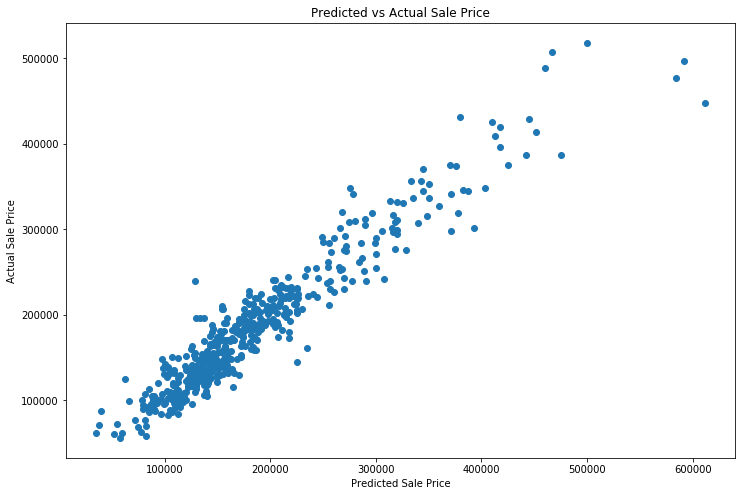

In [21]:
plt.figure(figsize = (12, 8))
plt.scatter(np.exp(y_test), y_test_preds)
plt.title('Predicted vs Actual Sale Price')
plt.xlabel('Predicted Sale Price')
plt.ylabel('Actual Sale Price')
plt.savefig('./imgs/OLSActualPredComparision.png');

Okay, we're getting a linear relationship between predicted and actuals here, so our model is making progress.

In [22]:
test_residuals =np.exp(y_test) - y_test_preds

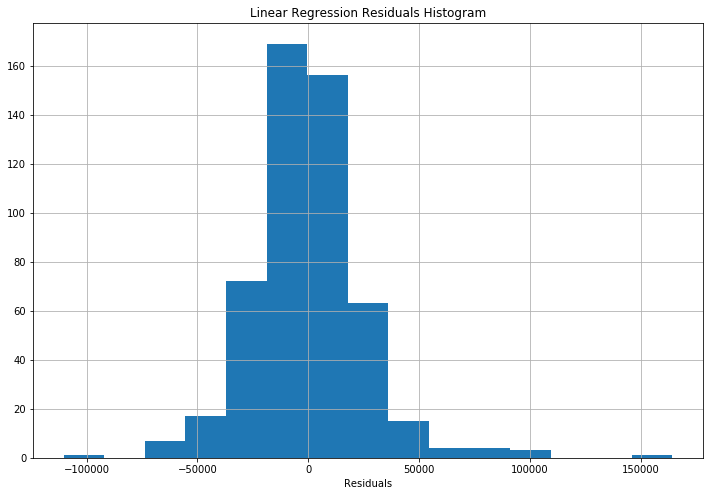

In [23]:
plt.figure(figsize = (12, 8))
test_residuals.hist(bins = 15)
plt.xlabel('Residuals')
plt.title('Linear Regression Residuals Histogram');
plt.savefig('./imgs/OLS Residuals Histogram.png');

Our residuals are showing a more normal distribution at this point with a slight negative skew.  A significant improvement over previous iterations.

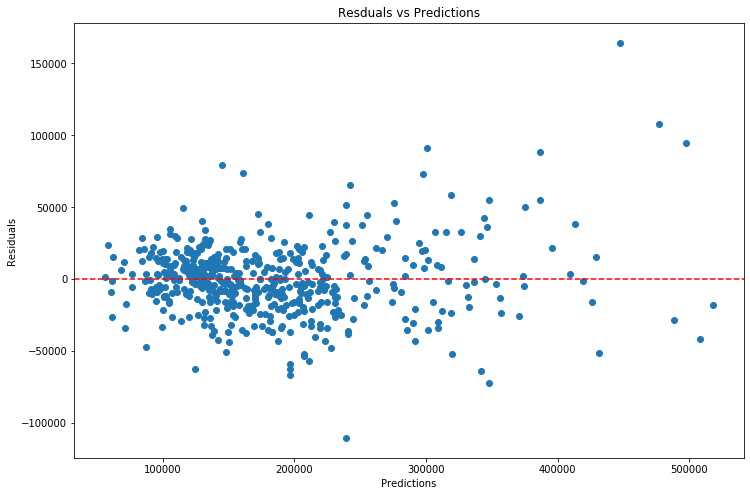

In [24]:
plt.figure(figsize = (12, 8))
plt.scatter(y_test_preds, test_residuals)
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.axhline(c = 'red', ls = 'dashed')
plt.title('Resduals vs Predictions');
plt.savefig('./imgs/Linear Regression Residuals vs Predictions.png');

We're showing a slight fanning with the residuals clustered at the smaller price range and becoming more spread out at higher values.  The model is better at predicting lower values.  This is the best option we're seeing so far.

__Evaluating LASSO__

In [25]:
cross_val_score(lasso_cv, Z_train, y_train)

array([0.88402585, 0.82059279, 0.86259746, 0.89574884, 0.87495283])

In [26]:
lasso_cv.score(Z_train, y_train), lasso_cv.score(Z_test, y_test)

(0.8763788692311599, 0.8863419220066522)

In [27]:
l_preds = np.exp(lasso_cv.predict(Z_test))

In [28]:
l_resids = np.exp(y_test) - l_preds

In [29]:
l_rmse = mean_squared_error(np.exp(y_test), l_preds) ** 0.5
l_rmse

25007.70049313173

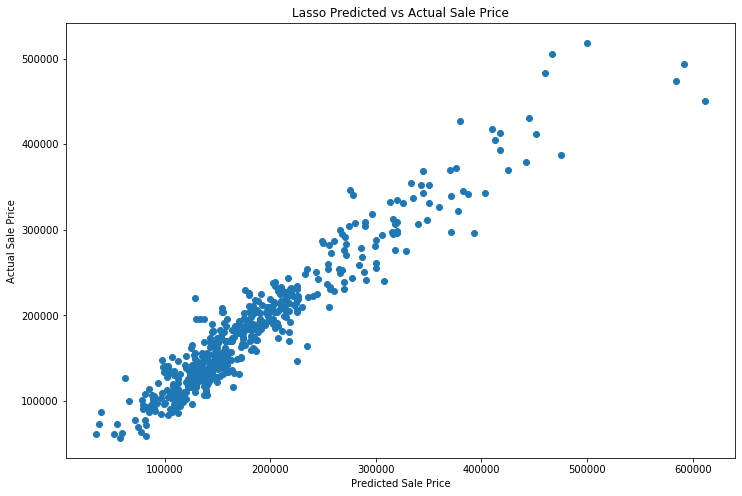

In [30]:
plt.figure(figsize = (12, 8))
plt.scatter(np.exp(y_test), l_preds)
plt.title('Lasso Predicted vs Actual Sale Price')
plt.xlabel('Predicted Sale Price')
plt.ylabel('Actual Sale Price');
plt.savefig('./imgs/LSCVActualPredComparision.png');

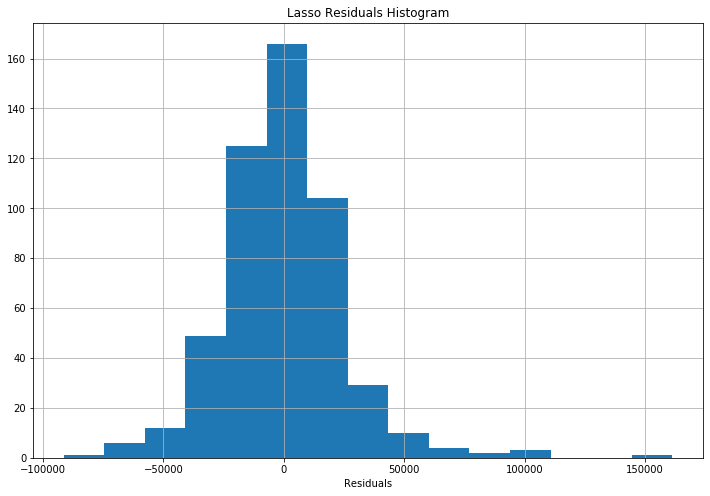

In [31]:
plt.figure(figsize = (12, 8))
l_resids.hist(bins = 15)
plt.xlabel('Residuals')
plt.title('Lasso Residuals Histogram')
plt.savefig('./imgs/LASSO CV Residuals Histogram.png');

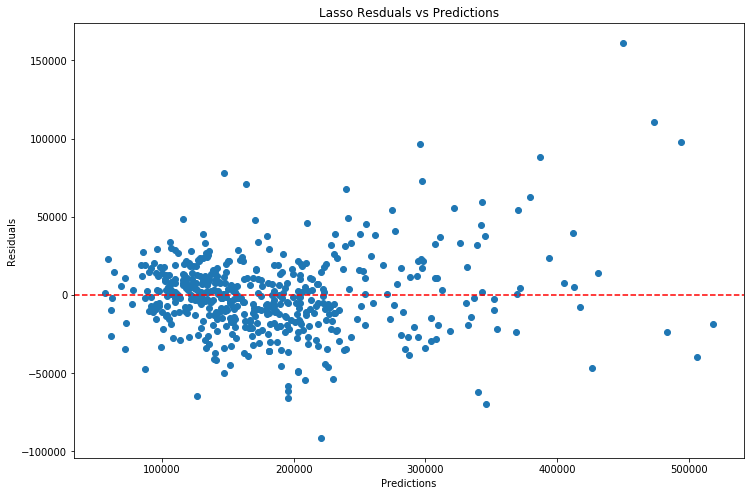

In [32]:
plt.figure(figsize = (12, 8))
plt.scatter(l_preds, l_resids)
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.axhline(c = 'red', ls = 'dashed')
plt.title('Lasso Resduals vs Predictions');
plt.savefig('./imgs/Lasso Residuals vs Predictions.png');

__Evaluating Ridge Regression__

In [33]:
ridge_cv.score(Z_train, y_train), ridge_cv.score(Z_test, y_test)

(0.8773401430181496, 0.885407561710244)

In [34]:
cross_val_score(ridge_cv, Z_train, y_train)

array([0.88236894, 0.82168665, 0.86192742, 0.89607251, 0.87413257])

In [35]:
r_preds = np.exp(ridge_cv.predict(Z_test))

In [36]:
r_resids = np.exp(y_test) - r_preds

In [37]:
r_rmse = mean_squared_error(np.exp(y_test), r_preds) ** 0.5
r_rmse

25123.961671237357

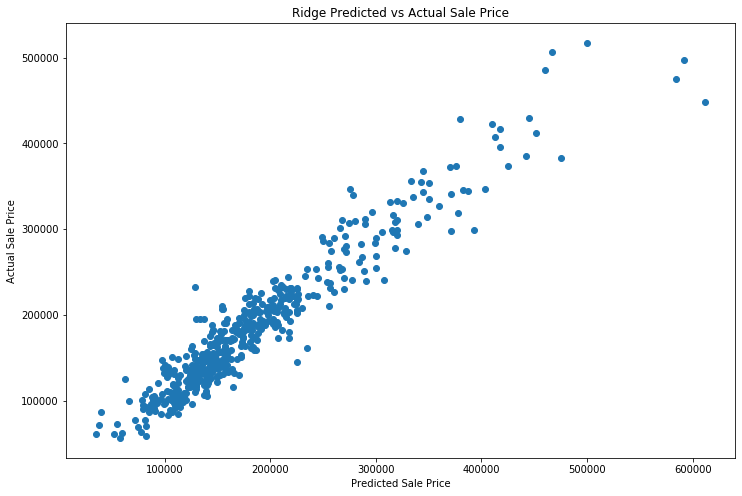

In [38]:
plt.figure(figsize = (12, 8))
plt.scatter(np.exp(y_test), r_preds)
plt.title('Ridge Predicted vs Actual Sale Price')
plt.xlabel('Predicted Sale Price')
plt.ylabel('Actual Sale Price')
plt.savefig('./imgs/RidgeActualPredComparision.png');

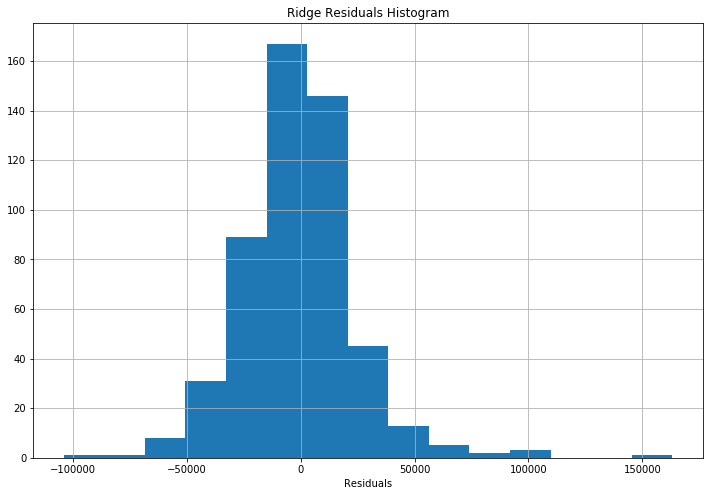

In [39]:
plt.figure(figsize = (12, 8))
r_resids.hist(bins = 15)
plt.xlabel('Residuals')
plt.title('Ridge Residuals Histogram')
plt.savefig('./imgs/Ridge Residuals Histogram.png');

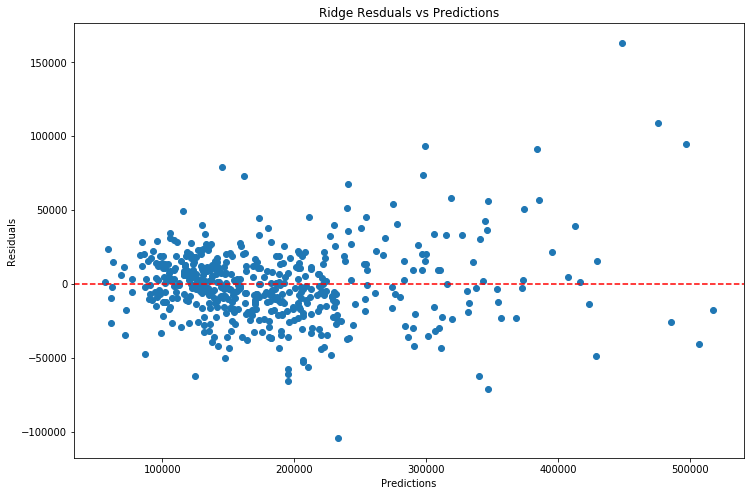

In [40]:
plt.figure(figsize = (12, 8))
plt.scatter(r_preds, r_resids)
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.axhline(c = 'red', ls = 'dashed')
plt.title('Ridge Resduals vs Predictions');
plt.savefig('./imgs/Ridge Residuals vs Predictions.png');

In [41]:
columns = pd.Series(X.columns, name = "col_name")
coefs   = pd.Series(ols.coef_, name = "coef")
coef_df = pd.concat([columns, coefs], axis = 1)
coef_df = coef_df.sort_values('coef', ascending = False)


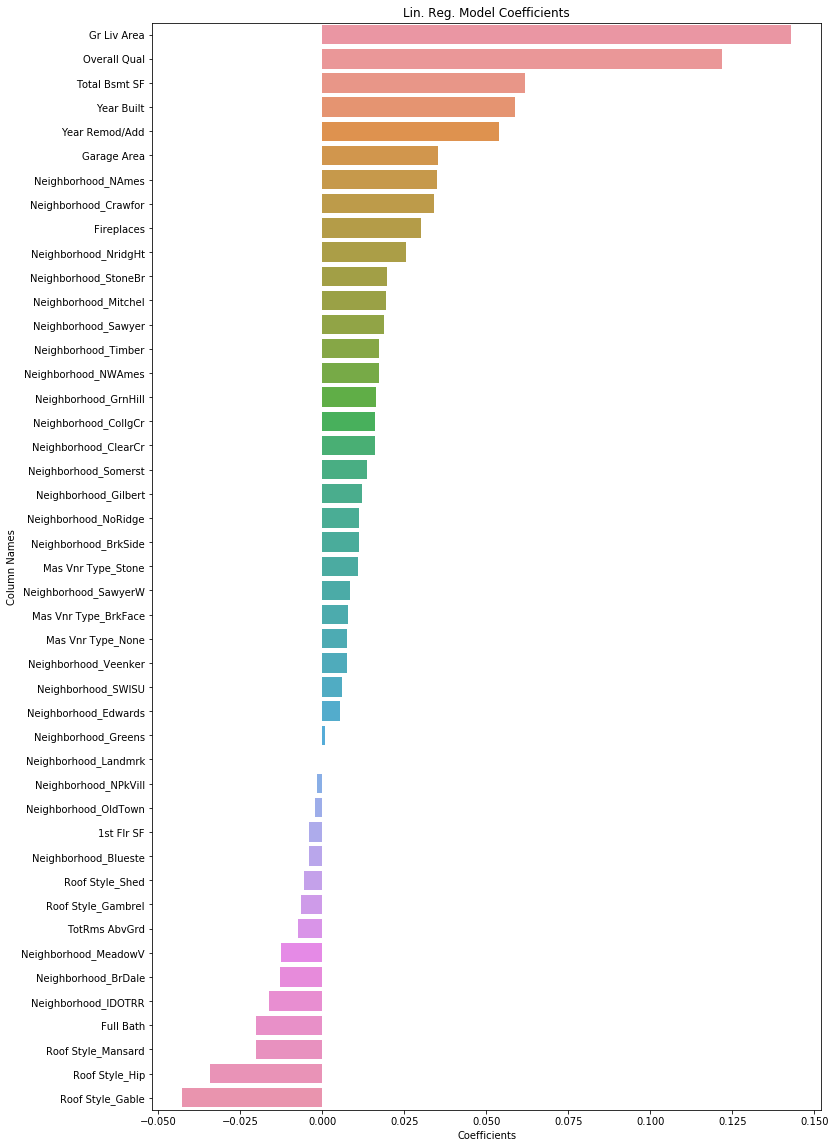

In [42]:
plt.figure(figsize = (12, 20))
plt.title('Lin. Reg. Model Coefficients')
sns.barplot(coef_df['coef'], coef_df['col_name']);
plt.xlabel('Coefficients')
plt.ylabel('Column Names');

In [43]:
neighborhood_coefs = coef_df[(coef_df['col_name'].str.contains('Neigh'))]

In [44]:
pos_diff_ns = neighborhood_coefs[neighborhood_coefs['coef'] >= 0]

neg_dif_ns = neighborhood_coefs[neighborhood_coefs['coef'] <= 0]

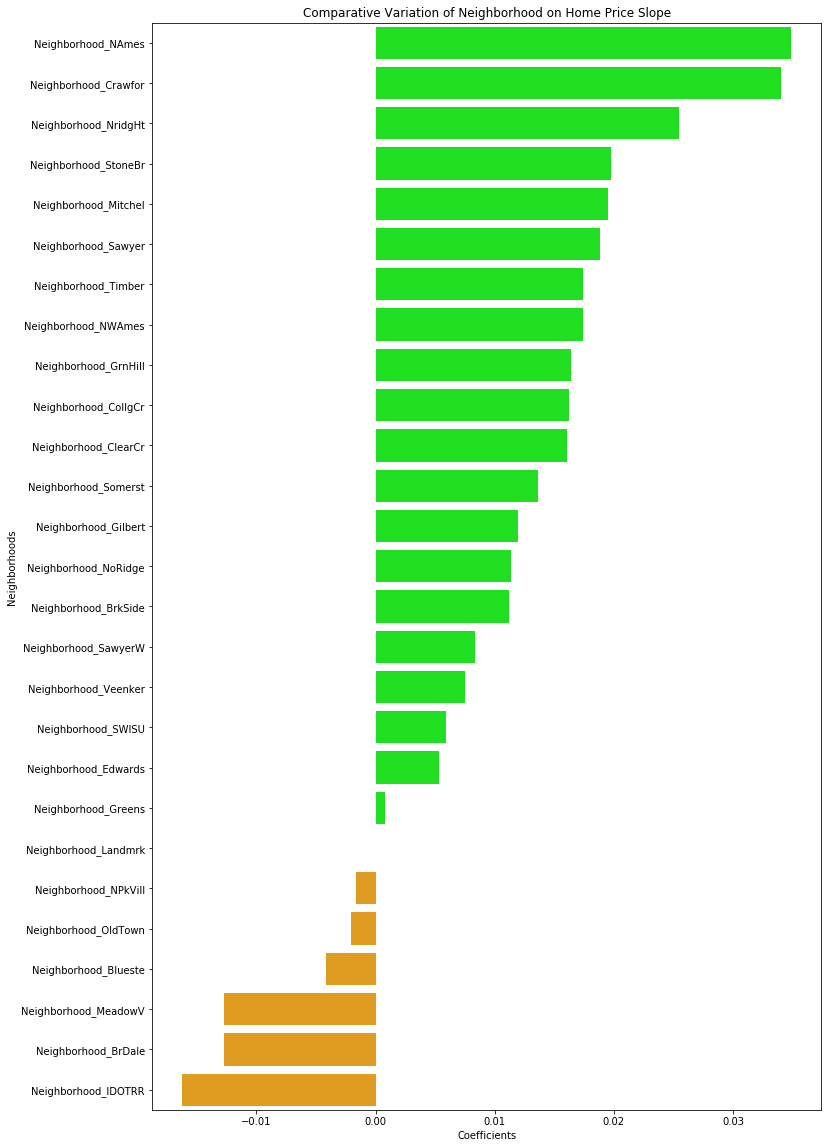

In [45]:
plt.figure(figsize = (12, 20))
plt.title('Comparative Variation of Neighborhood on Home Price Slope')
sns.barplot(pos_diff_ns['coef'], neighborhood_coefs['col_name'], color = 'lime')
sns.barplot(neg_dif_ns['coef'], neighborhood_coefs['col_name'], color = 'orange')
plt.xlabel('Coefficients')
plt.ylabel('Neighborhoods');